<a href="https://colab.research.google.com/github/colin-ho/colin-ho-twitter/blob/main/twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and file reads

In [ ]:
import pandas as pd 
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional,LSTM
from tensorflow.keras.layers import Conv1D,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import metrics

import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-01-09 00:45:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-09 00:45:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-09 00:45:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
df = pd.read_csv ('data.csv')
df.head()

,valence,author,tweet
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,scotthamilton,is upset that he can't update his Facebook by ...
2,0,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,ElleCTF,my whole body feels itchy and like its on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df = df[['valence','tweet']]
df.head()

,valence,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Valence Data Distribution')

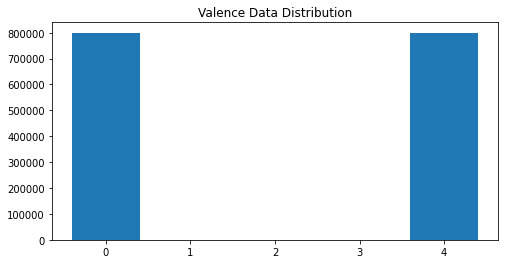

In [ ]:
value_count = df.valence.value_counts()

plt.figure(figsize=(8,4))
plt.bar(value_count.index, value_count.values)
plt.title("Valence Data Distribution")

## Preprocessing

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
df.tweet = df.tweet.apply(lambda x: preprocess(x))

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2,
                                         random_state=7)
print("Train size:", len(train_data))
print("Test size", len(test_data))

Train size: 1280000
Test size 320000


In [ ]:
train_data.head(10)

,valence,tweet
23786,0,need friends
182699,0,im trying call impossible
476661,0,good pace going 3k 13 min missed 5k turn ended...
1181490,4,u gonna shows ny soon luv see u live
878773,4,hell yea get em tattoos ink free wish parents ...
130866,0,yeah need 2 see ur mom calls back first rememb...
1235876,4,sounds like cup tea sign
717314,0,tired want sleep wtf
969880,4,amazing wish
748698,0,thank god wkrn abc affiliate nashville back mi...


## Tokenizing

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweet)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size:", vocab_size)

Vocab Size: 290575


In [ ]:
LENGTH = 30

In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet),
                        maxlen = LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet),
                       maxlen = LENGTH)

print("X Train Shape:",x_train.shape)
print("Y Train Shape:",x_test.shape)

X Train Shape: (1280000, 30)
Y Train Shape: (320000, 30)


In [ ]:
labels = train_data.valence.unique().tolist()
encoder = LabelEncoder()
encoder.fit(train_data.valence.to_list())

y_train = encoder.transform(train_data.valence.to_list())
y_test = encoder.transform(test_data.valence.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("Y Train shape:", y_train.shape)
print("Y Test shape:", y_test.shape)

Y Train shape: (1280000, 1)
Y Test shape: (320000, 1)


## Embeddings

In [ ]:
embeddings_index = {}

f = open('glove.6B.50d.txt')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

## Model

In [ ]:
reduce_lr = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
callbacks = [reduce_lr]

In [ ]:
def define_model():
    model = Sequential()

    model.add(Embedding(len(word_index) + 1,embedding_matrix.shape[1], input_length=LENGTH,trainable = False, weights = [embedding_matrix]))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(Bidirectional(LSTM(64,dropout=0.2)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1,activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = [metrics.binary_accuracy])
    
    model.summary()

    return model

In [ ]:
model = define_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 50)            14528750  
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 128)           25728     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 512)               66048     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                      

In [ ]:
history = model.fit(x_train, y_train, batch_size=1024, epochs=10,
                    validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/10
1250/1250 [==============================] - 79s 60ms/step - loss: 0.5431 - binary_accuracy: 0.7199 - val_loss: 0.5090 - val_binary_accuracy: 0.7467 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 74s 59ms/step - loss: 0.5049 - binary_accuracy: 0.7492 - val_loss: 0.4928 - val_binary_accuracy: 0.7586 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 74s 59ms/step - loss: 0.4900 - binary_accuracy: 0.7595 - val_loss: 0.4868 - val_binary_accuracy: 0.7620 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 74s 59ms/step - loss: 0.4815 - binary_accuracy: 0.7654 - val_loss: 0.4760 - val_binary_accuracy: 0.7698 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 73s 59ms/step - loss: 0.4750 - binary_accuracy: 0.7699 - val_loss: 0.4715 - val_binary_accuracy: 0.7720 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 74s 59ms/step - loss: 0.4698 - binary_accuracy: 0.7733 - val_loss: 0.4686 - val

## Results

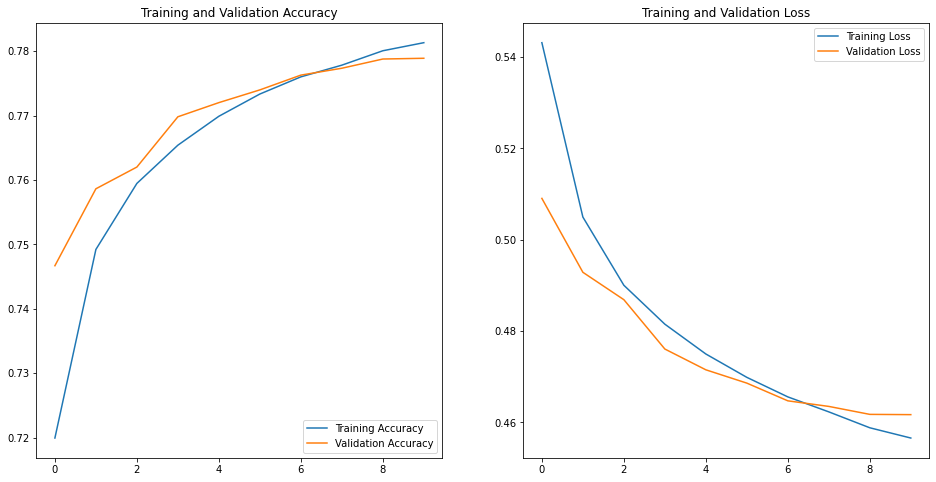

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 4s 104ms/step


In [ ]:

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [ ]:
lab_to_valence = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_valence[label]
test_data.valence = test_data.valence.apply(lambda x: label_decoder(x))

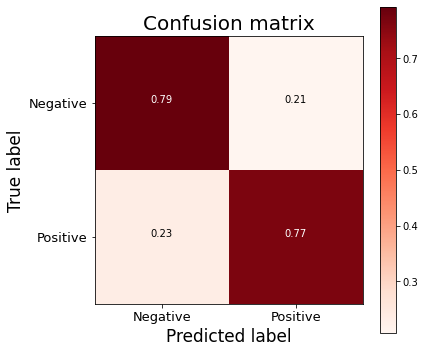

In [ ]:
cnf_matrix = confusion_matrix(test_data.valence.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.valence.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(list(test_data.valence), y_pred_1d))


              precision    recall  f1-score   support

    Negative       0.77      0.79      0.78    160542
    Positive       0.79      0.77      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

